# Quantum Support Vector Machine

1. [Quantum Kernel](#Quantum-Kernel) \
    1.1 [Custom Implementation with Qiskit Circuit](#Custom-Implementation-with-Qiskit-Circuit) \
    1.2 [Qiskit Implementation](#Qiskit-Implementation) 
2. [Quantum Support Vector Machine](#Quantum-Support-Vector-Machine)

In [76]:
from quantum_svm.quantum.feature_maps import ZZFeatureMap as ZZFeatureMap_custom
from quantum_svm.quantum.feature_maps import ZFeatureMap as ZFeatureMap_custom
from quantum_svm.quantum.kernels import QuantumKernel as QuantumKernel_custom
from quantum_svm.quantum.kernel_loader import quantum_kernel_loader
from quantum_svm.quantum.data_maps import DataMap, DataMap_Exp, DataMap_Sin, DataMap_Cos
from quantum_svm.svm.nonlinear_classifier import kernelSVC
from quantum_svm.utils.plot import plot_kernel_SVC, plot_confusion_matrix
from quantum_svm.utils.utils import compare_models, compare_model_performance, accuracy
from quantum_svm.data.data_generators import (
    create_XOR_data, 
    create_moons_data, 
    create_circles_data, 
    adhoc_dataset
)
import matplotlib.pyplot as plt
import matplotlib.colors as pltcolors
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np

from qiskit import BasicAer, Aer
from qiskit_machine_learning.kernels import QuantumKernel
from qiskit.circuit.library import ZZFeatureMap, PauliFeatureMap, ZFeatureMap
from qiskit.utils import algorithm_globals
from qiskit_machine_learning.algorithms import QSVC


from sklearn.svm import SVC

%load_ext autoreload

%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Quantum Kernel 
### Validation of Custom Implementation

In [2]:
# Initialize Random Data
X = np.random.rand(80,2)

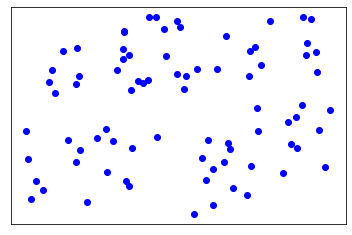

In [3]:
plt.scatter(X[:,0], X[:,1], c='b')
plt.xticks([])
plt.yticks([]);

#### Theory
In order to use a quantum kernels, one needs to transform the classical data to a quantum state.
#### Quantum Feature Maps 
- maps a classical state vector x to a quantum state vector (Hilbert Space)
- this is done by $$ \mathbf{U}_{\Phi}(x) = \prod_d U_{\Phi}(x)\mathbb{H}^{\otimes n}$$
**ZZ Feature Map**
$$ \mathbf{U}_{\Phi}(x) = ( \exp(i \sum_{jk} \phi_{j,k}(x) Z_j \otimes Z_k) \exp(i \sum_{j} \phi_{j}(x) Z_j)  \mathbb{H}^{\otimes n})^d$$
The feature map is realized by a quantum circuit.  
#### Quantum Kernel

$$ k(x_i, x_j) = \Phi^{\dagger}(x_i) \Phi(x_j)$$ 
for finite data:
$$ K_{ij} = |<\Phi^{\dagger}(x_i)|\Phi(x_j)>|^2 $$

$$|\Phi(x_j)> = U_{\theta}(x_j)|0^{\otimes n}>$$

to calculate each element --> calc the transition amplitude 
$$ |<\Phi^{\dagger}(x_i)|\Phi(x_j)>|^2 = |<0^{\otimes n}|U_{\theta}^{\dagger}(x_i)|U_{\theta}(x_j)|0^{\otimes n}>|^2$$


### Custom Implementation with Qiskit Circuit

In [4]:
quantum_params = {
    'feature_dimension': 2,
    'reps': 1,
    'seed': 1024,
    'shots': 2**14,   
    'provider_backend': None,
}

In [5]:
data_map = DataMap()

zz_map_custom = ZZFeatureMap_custom(
    quantum_params['feature_dimension'], 
    quantum_params['reps'], 
    data_map, 
    insert_barriers=True
)

zz_map_custom

ZZFeatureMap(feature_dimensions=2, reps=1)

In [6]:
backend = Aer.get_backend('qasm_simulator')

zz_kernel = QuantumKernel_custom(feature_map=zz_map_custom, quantum_backend=backend, sim_params=quantum_params)

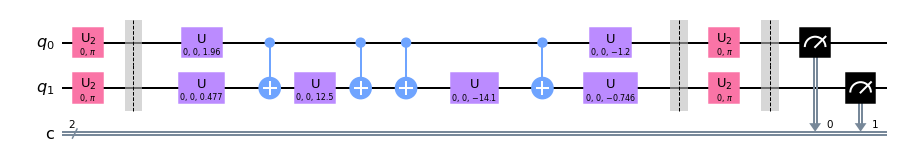

In [7]:
circuit = zz_kernel.construct_circuit(X[0], X[1])
circuit.decompose().decompose().draw('mpl')

In [8]:
QK_custom = zz_kernel.evaluate(X)

### Qiskit Implementation 

/Users/Maxi/.virtualenvs/svm_venv/lib/python3.7/site-packages/sympy/core/expr.py:3951: SymPyDeprecationWarning: 

expr_free_symbols method has been deprecated since SymPy 1.9. See
https://github.com/sympy/sympy/issues/21494 for more info.

  deprecated_since_version="1.9").warn()


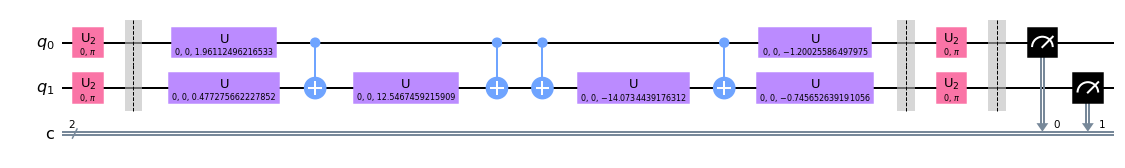

In [9]:
zz_map = ZZFeatureMap(feature_dimension=2, reps=1, entanglement='linear', insert_barriers=True)

zz_kernel = QuantumKernel(feature_map=zz_map, quantum_instance=Aer.get_backend('qasm_simulator'))

zz_circuit = zz_kernel.construct_circuit(X[0], X[1])
zz_circuit.decompose().decompose().decompose().draw(output='mpl')

In [10]:
QK_qiskit = zz_kernel.evaluate(X)

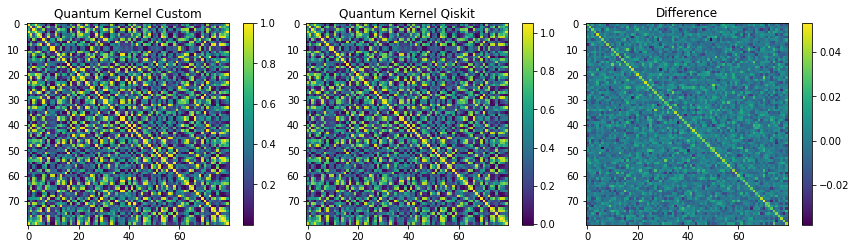

In [11]:
fig, ax = plt.subplots(1, 3, figsize=(12, 12))
im = ax[0].imshow(np.asmatrix(QK_custom),
              interpolation='nearest', origin='upper', cmap=plt.cm.viridis)
divider = make_axes_locatable(ax[0])
cax = divider.append_axes("right", size="5%", pad=0.2)
plt.colorbar(im, cax=cax)

ax[0].set_title("Quantum Kernel Custom")
im = ax[1].imshow(np.asmatrix(QK_qiskit),
              interpolation='nearest', origin='upper', cmap=plt.cm.viridis)
ax[1].set_title("Quantum Kernel Qiskit")
divider = make_axes_locatable(ax[1])
cax = divider.append_axes("right", size="5%", pad=0.2)
plt.colorbar(im, cax=cax)

im = ax[2].imshow(QK_qiskit - QK_custom, interpolation='nearest', origin='upper', cmap=plt.cm.viridis)
ax[2].set_title("Difference")
divider = make_axes_locatable(ax[2])
cax = divider.append_axes("right", size="5%", pad=0.2)
plt.colorbar(im, cax=cax)

fig.tight_layout()
plt.show()

## Quantum Support Vector Machine

In [12]:
alpha_tol = 1e-04
colors = ['red', 'blue']
cmap_custom = pltcolors.ListedColormap(colors)
cmap = plt.cm.RdBu_r


seed = 12

In [13]:
# Params

center = 1
params_xor = {
    'N': 100, # number of samples
    'D': 2, # number of dimensions
    'sigma': 0.4, # std
    'centers': [[center,center], [-center,center], [center,-center], [-center,-center]], 
    'seed': seed,
}

params_adhoc = {
    'train_size': 40,
    'test_size': 10,
    'adhoc_dimension': 2,
    'gap': 0.3,
}

In [14]:
datasets = [
    create_XOR_data(
        params_xor['N'], 
        params_xor['D'], 
        params_xor['centers'], 
        params_xor['sigma'], 
        params_xor['seed']
    ),
    adhoc_dataset(
        params_adhoc['train_size'], 
        params_adhoc['test_size'], 
        params_adhoc['adhoc_dimension'],
        params_adhoc['gap']
    ),
]

### Compare custom QSVC with qiskit QSVC

In [15]:
# Load Data
X_xor_train, X_xor_test, y_xor_train, y_xor_test = datasets[0]

In [16]:
quantum_params = {
    'feature_dimension': 2,
    'reps': 2,
    'seed': 1024,
    'shots': 2**14,   
    'provider_backend': Aer.get_backend('qasm_simulator'),
}

data_map = DataMap()

# set up quntum kernel 
quantum_SVC = kernelSVC(
    kernel='quantum', 
    quantum_params=quantum_params,
    data_map=data_map,
    qiskit=False
)

SVC(kernel='quantum, feature_map='ZZFeatureMap', data_map='phi_S : x --> {x if S={i}, (pi - x[0])(pi - x[0] if S={i,j})'')


In [17]:
# train 
quantum_SVC.fit(X_xor_train, y_xor_train)

Computing Quantum Kernel ...
Quantum Kernel computed!
Found 10 Support Vectors out of 80 data points




100%|████████████████████████████████████████| 80/80 [01:37<00:00,  1.22s/batch]

Accuracy on training set: 100.0 %


In [18]:
# Predict
y_xor_pred_quantum = quantum_SVC.predict(X_xor_test)

100%|████████████████████████████████████████| 20/20 [00:24<00:00,  1.22s/batch]


In [19]:
# adopted from IBM Quantum Lab - qiskit tutorials/wiskit-machine-learning/03_quantum_kernels
# https://lab.quantum-computing.ibm.com/user/6093c4e5b83b3765117f006a/lab/tree/qiskit-tutorials/qiskit-machine-learning/03_quantum_kernel.ipynb
algorithm_globals.random_seed = seed

adhoc_dimension = 2
adhoc_feature_map = ZZFeatureMap(feature_dimension=adhoc_dimension, 
                                 reps=2, entanglement='linear')

adhoc_backend = QuantumInstance(BasicAer.get_backend('qasm_simulator'), shots=1024,
                                seed_simulator=seed, seed_transpiler=seed)

adhoc_kernel = QuantumKernel(feature_map=adhoc_feature_map, quantum_instance=adhoc_backend)

In [20]:
# Initialize
qsvc = QSVC(quantum_kernel=adhoc_kernel)
# Fit
qsvc.fit(X_xor_train, y_xor_train)
qsvc_score = qsvc.score(X_xor_test, y_xor_test)
qsvc_pred = qsvc.predict(X_xor_test)

# adopted from IBM Quantum Lab - qiskit tutorials/wiskit-machine-learning/03_quantum_kernels

100%|██████████████████████████████████████| 400/400 [08:08<00:00,  1.22s/batch]


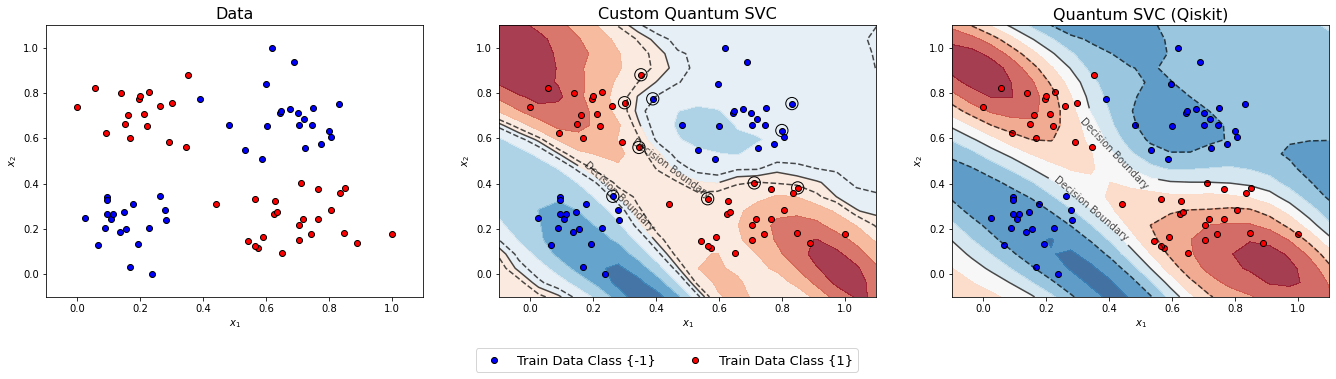

In [21]:
plot_kernel_SVC(
    X_xor_train, 
    y_xor_train, 
    [quantum_SVC, qsvc], 
    cmap, 
    titles=["Data", "Custom Quantum SVC", "Quantum SVC (Qiskit)"], 
    kernel='quantum')


Accuracy on test set: 95.0 %
Baseline Accuracy: 95.0 %


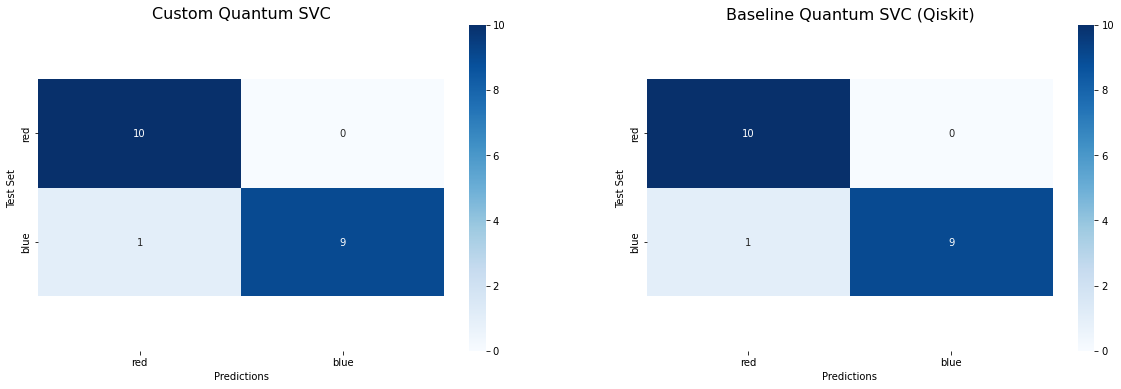

In [56]:
# accuracy
accuracy(y_xor_test, y_xor_pred_quantum, True, mode='test')
print(f'Baseline Accuracy: {qsvc_score*100} %')

# confusion Matrix plot
plot_confusion_matrix(
    y_xor_test, 
    y_xor_pred_quantum,
    qsvc_pred,
    colors, 
    titles=["Custom Quantum SVC", "Baseline Quantum SVC (Qiskit)"]
)

### Adhoc Dataset

https://arxiv.org/pdf/1804.11326.pdf

In [28]:
# Load Data
X_adhoc_train, y_adhoc_train, X_adhoc_test, y_adhoc_test, adhoc_total = datasets[-1]

### Radial Basis Function (rbf)

In [37]:
# Initialize Model
rbf_SVC_adhoc = kernelSVC(kernel='rbf', C=10)

# Fit Model
rbf_SVC_adhoc.fit(X_adhoc_train, y_adhoc_train)

SVC(kernel='rbf', C=10.0, gamma=0.5)
Found 55 Support Vectors out of 80 data points




100%|██████████████████████████████████████| 80/80 [00:00<00:00, 1689.40batch/s]


Accuracy on training set: 91.25 %


In [38]:
# Predict
y_adhoc_pred_rbf = rbf_SVC_adhoc.predict(X_adhoc_test)

100%|██████████████████████████████████████| 20/20 [00:00<00:00, 1222.12batch/s]


In [39]:
# Baseline 
baseline_rbf_kernel_SVC_adhoc = SVC(kernel='rbf', C=10, gamma=0.5)

# Fit
baseline_rbf_kernel_SVC_adhoc.fit(X_adhoc_train, y_adhoc_train)

SVC(C=10, gamma=0.5)

In [40]:
# Predict
y_adhoc_pred_baseline_rbf = baseline_rbf_kernel_SVC_adhoc.predict(X_adhoc_test)

# Accuracy
baseline_acc_rbf_adhoc = baseline_rbf_kernel_SVC_adhoc.score(X_adhoc_test, y_adhoc_test)

100%|██████████████████████████████████| 2500/2500 [00:00<00:00, 2600.31batch/s]


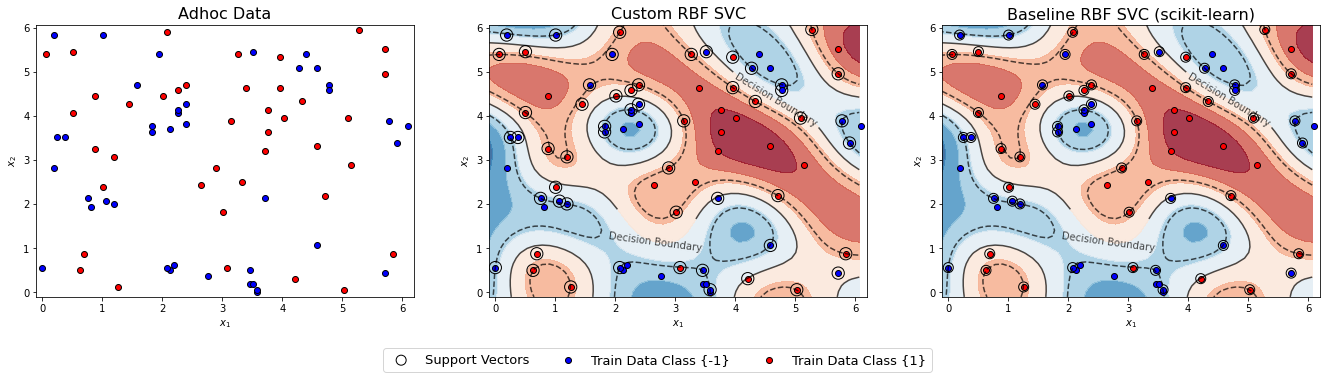

In [41]:
plot_kernel_SVC(
    X_adhoc_train, 
    y_adhoc_train, 
    [rbf_SVC_adhoc, baseline_rbf_kernel_SVC_adhoc], 
    cmap, 
    titles=["Adhoc Data", "Custom RBF SVC", "Baseline RBF SVC (scikit-learn)"], 
    kernel='rbf'
)

Accuracy on test set: 70.0 %
Baseline Accuracy: 70.0 %


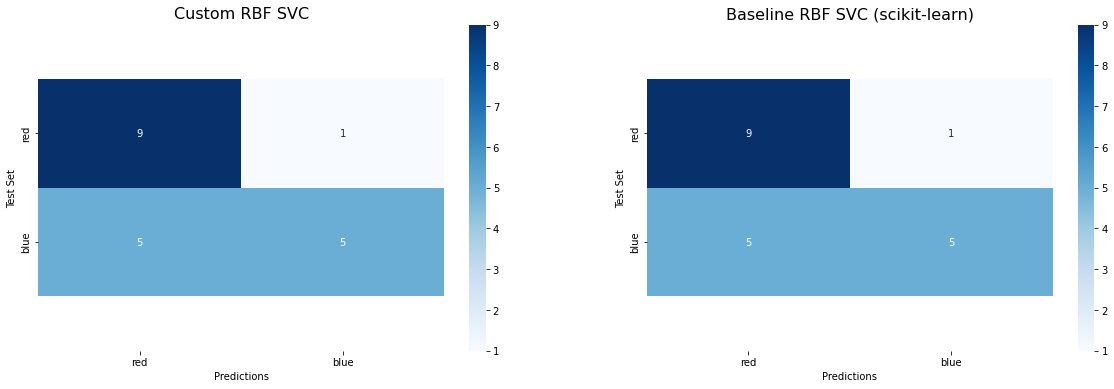

In [50]:
# accuracy
accuracy(y_adhoc_test, y_adhoc_pred_rbf, True, mode='test')
print(f'Baseline Accuracy: {baseline_acc_rbf_adhoc*100} %')

# confusion Matrix plot
plot_confusion_matrix(
    y_adhoc_test, 
    y_adhoc_pred_rbf,
    y_adhoc_pred_baseline_rbf,
    colors, 
    titles=["Custom RBF SVC", "Baseline RBF SVC (scikit-learn)"]
)

### Compare Quantum Kernel to rbf Kernel on adhoc data

In [91]:
quantum_params = {
    'feature_dimension': 2,
    'reps': 2,
    'seed': 1024,
    'shots': 2**14,   
    'provider_backend': Aer.get_backend('qasm_simulator'),
}

data_map = DataMap()

# set up quntum kernel 
quantum_SVC = kernelSVC(
    kernel='quantum', 
    quantum_params=quantum_params,
    feature_map=ZZFeatureMap_custom,
    data_map=data_map,
    qiskit=False
)

SVC(kernel='quantum', feature_map='<class 'quantum_svm.quantum.feature_maps.ZZFeatureMap'>', data_map='phi_S : x --> {x if S={i}, (pi - x[0])(pi - x[0]) if S={i,j}')


In [46]:
# train 
quantum_SVC.fit(X_adhoc_train, y_adhoc_train)

Computing Quantum Kernel ...
Quantum Kernel computed!
Found 13 Support Vectors out of 80 data points




100%|████████████████████████████████████████| 80/80 [02:38<00:00,  1.98s/batch]


Accuracy on training set: 100.0 %


In [47]:
# predict
y_adhoc_pred_quantum = quantum_SVC.predict(X_adhoc_test)

100%|████████████████████████████████████████| 20/20 [00:40<00:00,  2.02s/batch]


100%|██████████████████████████████████████| 400/400 [15:03<00:00,  2.26s/batch]


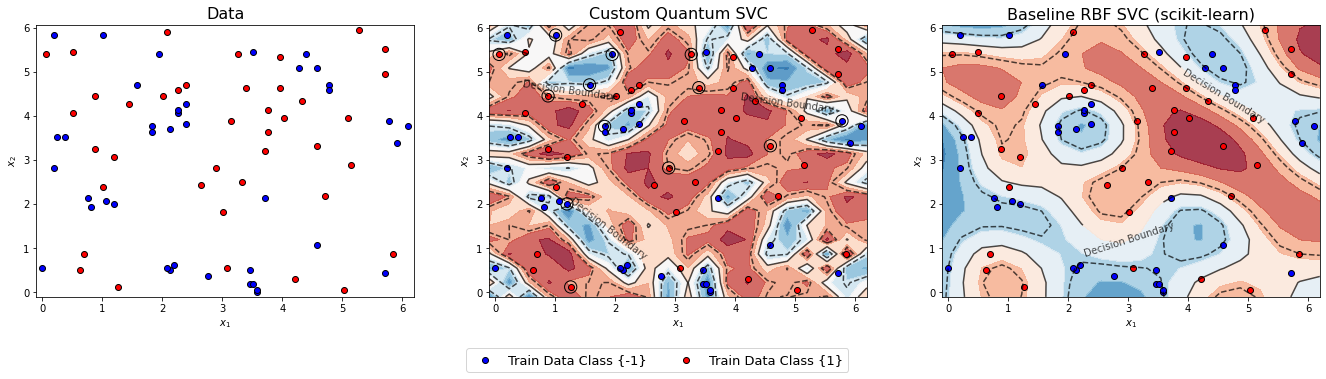

In [48]:
plot_kernel_SVC(
    X_adhoc_train, 
    y_adhoc_train, 
    [quantum_SVC, rbf_SVC_adhoc], 
    cmap, 
    titles=["Data", "Custom Quantum SVC", "Custom RBF SVC"], 
    kernel='quantum')

Accuracy on test set: 100.0 %
Accuracy on test set: 70.0 %


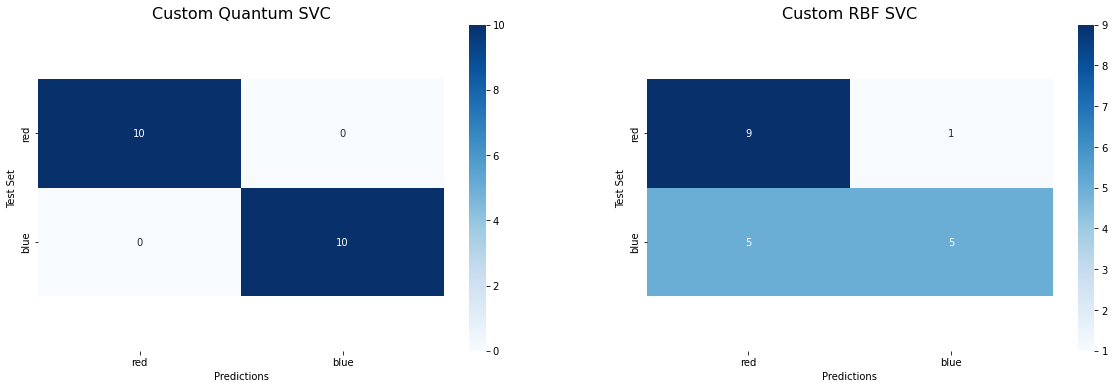

In [49]:
# accuracy
accuracy(y_adhoc_test, y_adhoc_pred_quantum, True, mode='test')
accuracy(y_adhoc_test, y_adhoc_pred_rbf, True, mode='test')

# confusion Matrix plot
plot_confusion_matrix(
    y_adhoc_test, 
    y_adhoc_pred_quantum,
    y_adhoc_pred_rbf,
    colors, 
    titles=["Custom Quantum SVC", "Custom RBF SVC"]
)

### Compare different Feature Maps 

#### ZZFeatureMap

In [100]:
quantum_params = {
    'feature_dimension': 2,
    'reps': 1,
    'seed': 1024,
    'shots': 2**14,   
    'provider_backend': None,
}

data_map = DataMap()

zz_map_custom = ZZFeatureMap_custom(
    quantum_params['feature_dimension'], 
    quantum_params['reps'], 
    data_map, 
    insert_barriers=True
)

zz_map_custom

ZZFeatureMap(feature_dimensions=2, reps=1)

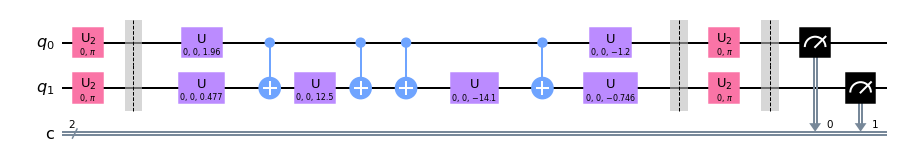

In [101]:
backend = Aer.get_backend('qasm_simulator')

zz_kernel = QuantumKernel_custom(feature_map=zz_map_custom, quantum_backend=backend, sim_params=quantum_params)

circuit = zz_kernel.construct_circuit(X[0], X[1])
circuit.decompose().decompose().draw('mpl')

#### ZFeatureMap

In [102]:
quantum_params = {
    'feature_dimension': 2,
    'reps': 1,
    'seed': 1024,
    'shots': 2**14,   
    'provider_backend': None,
}

data_map = DataMap()

z_map_custom = ZFeatureMap_custom(
    quantum_params['feature_dimension'], 
    quantum_params['reps'], 
    data_map, 
    insert_barriers=True
)

z_map_custom


ZFeatureMap(feature_dimensions=2, reps=1)

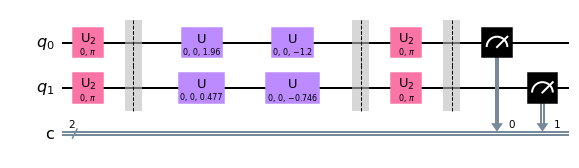

In [103]:
backend = Aer.get_backend('qasm_simulator')

z_kernel = QuantumKernel_custom(feature_map=z_map_custom, quantum_backend=backend, sim_params=quantum_params)

circuit = z_kernel.construct_circuit(X[0], X[1])
circuit.decompose().decompose().draw('mpl')

#### Comparison

In [104]:
quantum_params = {
    'feature_dimension': 2,
    'reps': 2,
    'seed': 1024,
    'shots': 2**14,   
    'provider_backend': Aer.get_backend('qasm_simulator'),
}

data_map = DataMap()

# set up quntum kernel 
quantum_SVC_z = kernelSVC(
    kernel='quantum', 
    quantum_params=quantum_params,
    feature_map=ZFeatureMap_custom,
    data_map=data_map,
    qiskit=False
)

quantum_SVC_zz = kernelSVC(
    kernel='quantum', 
    quantum_params=quantum_params,
    feature_map=ZZFeatureMap_custom,
    data_map=data_map,
    qiskit=False
)

SVC(kernel='quantum', feature_map='<class 'quantum_svm.quantum.feature_maps.ZFeatureMap'>', data_map='phi_S : x --> {x if S={i}, (pi - x[0])(pi - x[0]) if S={i,j}')
SVC(kernel='quantum', feature_map='<class 'quantum_svm.quantum.feature_maps.ZZFeatureMap'>', data_map='phi_S : x --> {x if S={i}, (pi - x[0])(pi - x[0]) if S={i,j}')


In [105]:
# train 
quantum_SVC_z.fit(X_adhoc_train, y_adhoc_train)
quantum_SVC_zz.fit(X_adhoc_train, y_adhoc_train)

Computing Quantum Kernel ...
Quantum Kernel computed!
Found 80 Support Vectors out of 80 data points




100%|████████████████████████████████████████| 80/80 [08:21<00:00,  6.27s/batch]


Accuracy on training set: 63.74999999999999 %
Computing Quantum Kernel ...
Quantum Kernel computed!
Found 13 Support Vectors out of 80 data points




100%|████████████████████████████████████████| 80/80 [02:18<00:00,  1.73s/batch]


Accuracy on training set: 100.0 %


In [108]:
# predict
y_adhoc_pred_quantum_z = quantum_SVC_z.predict(X_adhoc_test)
y_adhoc_pred_quantum_zz = quantum_SVC_zz.predict(X_adhoc_test)

100%|████████████████████████████████████████| 20/20 [00:26<00:00,  1.33s/batch]


100%|██████████████████████████████████████| 400/400 [42:42<00:00,  6.41s/batch]


TypeError: 'numpy.ndarray' object is not callable

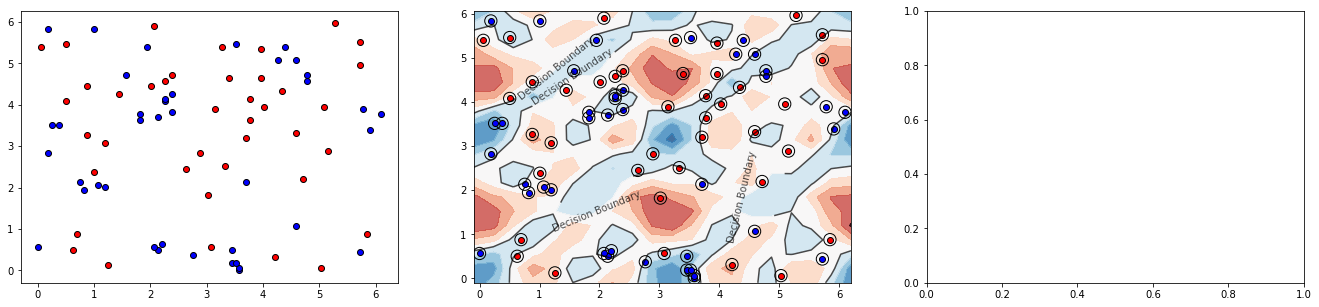

In [106]:
plot_kernel_SVC(
    X_adhoc_train, 
    y_adhoc_train, 
    [quantum_SVC_z, quantum_SVC_zz], 
    cmap, 
    titles=["Data", "Custom Quantum SVC - ZFeatureMap", "Custom Quantum SVC - ZZFeatureMap"], 
    kernel='quantum')

Accuracy on test set: 55.00000000000001 %
Accuracy on test set: 100.0 %


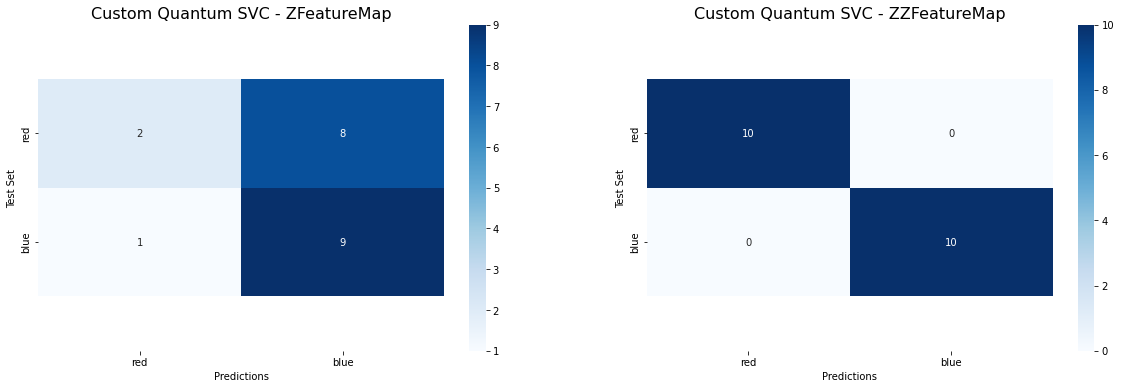

In [109]:
# accuracy
accuracy(y_adhoc_test, y_adhoc_pred_quantum_z, True, mode='test')
accuracy(y_adhoc_test, y_adhoc_pred_quantum_zz, True, mode='test')

# confusion Matrix plot
plot_confusion_matrix(
    y_adhoc_test, 
    y_adhoc_pred_quantum_z,
    y_adhoc_pred_quantum_zz,
    colors, 
    titles=["Custom Quantum SVC - ZFeatureMap", "Custom Quantum SVC - ZZFeatureMap"]
)

## Quantum Kernel Comparisons
### Datasets

In [171]:
# Params

center = 1
params_xor = {
    'N': 10, # number of samples
    'D': 2, # number of dimensions
    'sigma': 0.4, # std
    'centers': [[center,center], [-center,center], [center,-center], [-center,-center]], 
    'seed': seed,
}


params_circles = {
    'N': 10, # number of samples
    'factor': 0.4, 
    'noise': 0.1,
    'seed': seed,
}

params_moons = {
    'N': 10, # number of samples
    'noise': 0.15,
    'seed': seed,
}

params_adhoc = {
    'train_size': 10,
    'test_size': 5,
    'adhoc_dimension': 2,
    'gap': 0.3,
}

In [172]:
datasets = [
    create_XOR_data(
        params_xor['N'], 
        params_xor['D'], 
        params_xor['centers'], 
        params_xor['sigma'], 
        params_xor['seed']
    ),
    create_circles_data(
        params_circles['N'], 
        params_circles['factor'], 
        params_circles['noise'], 
        params_circles['seed']
    ),
    create_moons_data(
        params_moons['N'], 
        params_moons['noise'], 
        params_moons['seed']
    ),
    adhoc_dataset(
        params_adhoc['train_size'], 
        params_adhoc['test_size'], 
        params_adhoc['adhoc_dimension'],
        params_adhoc['gap']
    ),
]

### Classifiers

In [173]:
data_maps = [
    DataMap(), 
    DataMap_Exp(), 
    DataMap_Sin(), 
    DataMap_Cos()
]

In [182]:
quantum_params = {
    'feature_dimension': 2,
    'reps': 2,
    'seed': 1024,
    'shots': 2**14,   
    'provider_backend': Aer.get_backend('qasm_simulator'),
}


classifiers = []

for data_map in data_maps:
    classifiers.append( kernelSVC(
                            kernel='quantum', 
                            quantum_parans=quantum_params,
                            data_map=data_map,
                            qiskit=False,
                            verbose=True
                        ),
                      )

SVC(kernel='quantum, feature_map='ZZFeatureMap', data_map='phi_S : x --> {x if S={i}, (pi - x[0])(pi - x[0] if S={i,j})'')
SVC(kernel='quantum, feature_map='ZZFeatureMap', data_map='phi_S : x --> {x if S={i}, exp{(|x[i] - x[j]|^2/(8/ln(pi)))} if S={i,j})'')
SVC(kernel='quantum, feature_map='ZZFeatureMap', data_map='phi_S : x --> {x if S={i}, sin((pi - x[i]))sin((pi - x[j])) if S={i,j})'')
SVC(kernel='quantum, feature_map='ZZFeatureMap', data_map='phi_S : x --> {x if S={i}, pi/3*(1/(cos(x[i])cos(x[j]))) if S={i,j})'')


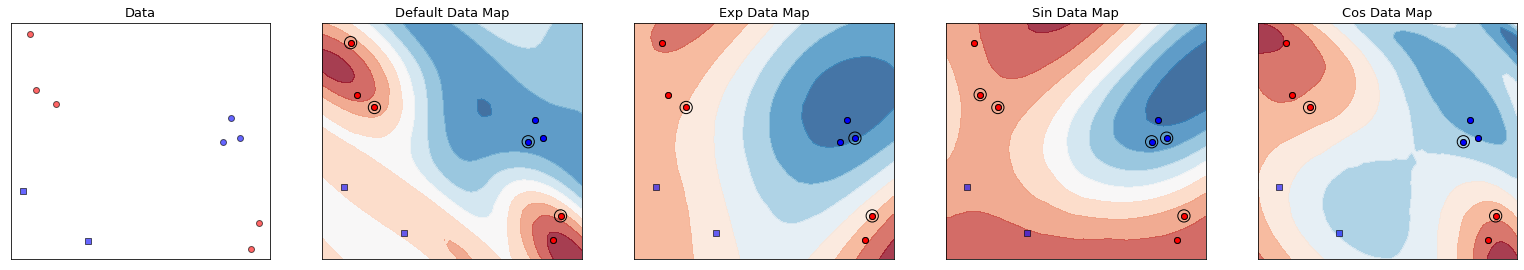

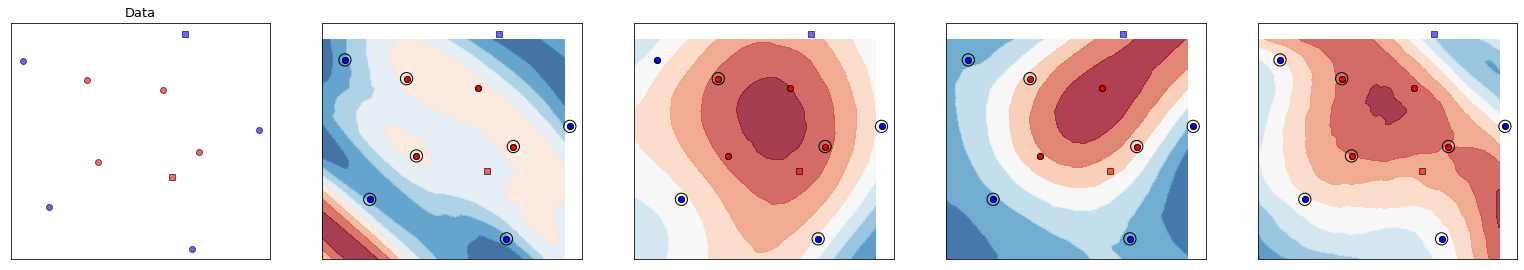

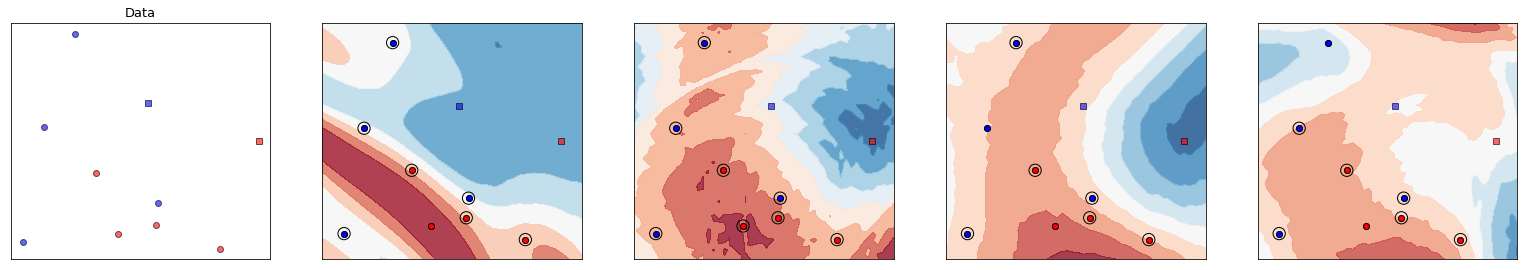

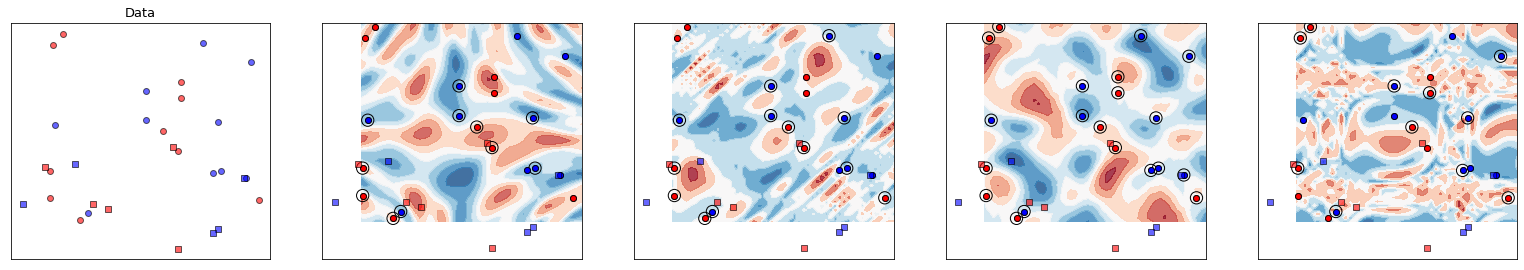

Time to compute: 535.7875156323115 min


In [175]:
compare_models(
    datasets, 
    classifiers, 
    ['Default Data Map',
     'Exp Data Map', 
     'Sin Data Map', 
     'Cos Data Map'],
)

In [178]:
# Params

center = 1
params_xor = {
    'N': 80, # number of samples
    'D': 2, # number of dimensions
    'sigma': 0.4, # std
    'centers': [[center,center], [-center,center], [center,-center], [-center,-center]], 
    'seed': seed,
}


params_circles = {
    'N': 80, # number of samples
    'factor': 0.4, 
    'noise': 0.1,
    'seed': seed,
}

params_moons = {
    'N': 80, # number of samples
    'noise': 0.15,
    'seed': seed,
}

params_adhoc = {
    'train_size': 40,
    'test_size': 2,
    'adhoc_dimension': 2,
    'gap': 0.3,
}

datasets = [
    create_XOR_data(
        params_xor['N'], 
        params_xor['D'], 
        params_xor['centers'], 
        params_xor['sigma'], 
        params_xor['seed']
    ),
    create_circles_data(
        params_circles['N'], 
        params_circles['factor'], 
        params_circles['noise'], 
        params_circles['seed']
    ),
    create_moons_data(
        params_moons['N'], 
        params_moons['noise'], 
        params_moons['seed']
    ),
    adhoc_dataset(
        params_adhoc['train_size'], 
        params_adhoc['test_size'], 
        params_adhoc['adhoc_dimension'],
        params_adhoc['gap']
    ),
]

In [184]:
model_performance_on_datamaps = compare_model_performance(
                                        datasets, 
                                        classifiers, 
                                        ['XOR Data', 'Cirles Data', 'Moons Data', 'Adhoc Data'],
                                        ['Default Data Map', 'Exp Data Map', 'Sin Data Map', 'Cos Data Map']
                                )


compute Default Data Map ...
Computing Quantum Kernel ...
Quantum Kernel computed!
Found 9 Support Vectors out of 64 data points




100%|████████████████████████████████████████| 64/64 [01:02<00:00,  1.02batch/s]


Accuracy on training set: 100.0 %


100%|████████████████████████████████████████| 16/16 [00:14<00:00,  1.13batch/s]


Default Data Map computed!
compute Exp Data Map ...
Computing Quantum Kernel ...
Quantum Kernel computed!
Found 61 Support Vectors out of 64 data points




100%|████████████████████████████████████████| 64/64 [06:40<00:00,  6.26s/batch]


Accuracy on training set: 96.875 %


100%|████████████████████████████████████████| 16/16 [01:38<00:00,  6.18s/batch]


Exp Data Map computed!
compute Sin Data Map ...
Computing Quantum Kernel ...
Quantum Kernel computed!
Found 64 Support Vectors out of 64 data points




100%|████████████████████████████████████████| 64/64 [06:53<00:00,  6.46s/batch]


Accuracy on training set: 96.875 %


100%|████████████████████████████████████████| 16/16 [01:46<00:00,  6.67s/batch]


Sin Data Map computed!
compute Cos Data Map ...
Computing Quantum Kernel ...
Quantum Kernel computed!
Found 9 Support Vectors out of 64 data points




100%|████████████████████████████████████████| 64/64 [01:00<00:00,  1.05batch/s]


Accuracy on training set: 96.875 %


100%|████████████████████████████████████████| 16/16 [00:15<00:00,  1.07batch/s]


Cos Data Map computed!
compute Default Data Map ...
Computing Quantum Kernel ...
Quantum Kernel computed!
Found 64 Support Vectors out of 64 data points




100%|████████████████████████████████████████| 64/64 [07:31<00:00,  7.05s/batch]


Accuracy on training set: 98.4375 %


100%|████████████████████████████████████████| 16/16 [01:46<00:00,  6.66s/batch]


Default Data Map computed!
compute Exp Data Map ...
Computing Quantum Kernel ...
Quantum Kernel computed!
Found 60 Support Vectors out of 64 data points




100%|████████████████████████████████████████| 64/64 [06:33<00:00,  6.15s/batch]


Accuracy on training set: 96.875 %


100%|████████████████████████████████████████| 16/16 [01:35<00:00,  5.97s/batch]


Exp Data Map computed!
compute Sin Data Map ...
Computing Quantum Kernel ...
Quantum Kernel computed!
Found 64 Support Vectors out of 64 data points




100%|████████████████████████████████████████| 64/64 [06:59<00:00,  6.56s/batch]


Accuracy on training set: 96.875 %


100%|████████████████████████████████████████| 16/16 [01:54<00:00,  7.15s/batch]


Sin Data Map computed!
compute Cos Data Map ...
Computing Quantum Kernel ...
Quantum Kernel computed!
Found 64 Support Vectors out of 64 data points




100%|████████████████████████████████████████| 64/64 [07:31<00:00,  7.06s/batch]


Accuracy on training set: 96.875 %


100%|████████████████████████████████████████| 16/16 [01:49<00:00,  6.85s/batch]


Cos Data Map computed!
compute Default Data Map ...
Computing Quantum Kernel ...
Quantum Kernel computed!
Found 62 Support Vectors out of 64 data points




100%|████████████████████████████████████████| 64/64 [07:31<00:00,  7.05s/batch]


Accuracy on training set: 85.9375 %


100%|████████████████████████████████████████| 16/16 [01:43<00:00,  6.48s/batch]


Default Data Map computed!
compute Exp Data Map ...
Computing Quantum Kernel ...
Quantum Kernel computed!
Found 64 Support Vectors out of 64 data points




100%|████████████████████████████████████████| 64/64 [07:59<00:00,  7.48s/batch]


Accuracy on training set: 89.0625 %


100%|████████████████████████████████████████| 16/16 [01:49<00:00,  6.86s/batch]


Exp Data Map computed!
compute Sin Data Map ...
Computing Quantum Kernel ...
Quantum Kernel computed!
Found 63 Support Vectors out of 64 data points




100%|████████████████████████████████████████| 64/64 [06:39<00:00,  6.24s/batch]


Accuracy on training set: 87.5 %


100%|████████████████████████████████████████| 16/16 [01:46<00:00,  6.65s/batch]


Sin Data Map computed!
compute Cos Data Map ...
Computing Quantum Kernel ...
Quantum Kernel computed!
Found 64 Support Vectors out of 64 data points




100%|████████████████████████████████████████| 64/64 [07:02<00:00,  6.61s/batch]


Accuracy on training set: 92.1875 %


100%|████████████████████████████████████████| 16/16 [01:45<00:00,  6.59s/batch]


Cos Data Map computed!
compute Default Data Map ...
Computing Quantum Kernel ...
Quantum Kernel computed!
Found 13 Support Vectors out of 80 data points




100%|████████████████████████████████████████| 80/80 [01:45<00:00,  1.32s/batch]


Accuracy on training set: 100.0 %


100%|██████████████████████████████████████████| 4/4 [00:05<00:00,  1.28s/batch]


Default Data Map computed!
compute Exp Data Map ...
Computing Quantum Kernel ...
Quantum Kernel computed!
Found 79 Support Vectors out of 80 data points




100%|████████████████████████████████████████| 80/80 [11:13<00:00,  8.42s/batch]


Accuracy on training set: 86.25 %


100%|██████████████████████████████████████████| 4/4 [00:31<00:00,  7.81s/batch]


Exp Data Map computed!
compute Sin Data Map ...
Computing Quantum Kernel ...
Quantum Kernel computed!
Found 80 Support Vectors out of 80 data points




100%|████████████████████████████████████████| 80/80 [11:53<00:00,  8.91s/batch]


Accuracy on training set: 81.25 %


100%|██████████████████████████████████████████| 4/4 [00:32<00:00,  8.05s/batch]


Sin Data Map computed!
compute Cos Data Map ...
Computing Quantum Kernel ...
Quantum Kernel computed!
Found 80 Support Vectors out of 80 data points




100%|████████████████████████████████████████| 80/80 [10:43<00:00,  8.04s/batch]


Accuracy on training set: 70.0 %


100%|██████████████████████████████████████████| 4/4 [00:31<00:00,  7.84s/batch]


Cos Data Map computed!
Performance on Adhoc Data computed


Time to compute: 196.1936976313591 min


In [185]:
model_performance_on_datamaps


{'XOR Data': {'Default Data Map': 0.9375,
  'Exp Data Map': 1.0,
  'Sin Data Map': 1.0,
  'Cos Data Map': 1.0},
 'Cirles Data': {'Default Data Map': 1.0,
  'Exp Data Map': 1.0,
  'Sin Data Map': 1.0,
  'Cos Data Map': 1.0},
 'Moons Data': {'Default Data Map': 0.6875,
  'Exp Data Map': 0.625,
  'Sin Data Map': 0.8125,
  'Cos Data Map': 0.8125},
 'Adhoc Data': {'Default Data Map': 1.0,
  'Exp Data Map': 0.5,
  'Sin Data Map': 0.75,
  'Cos Data Map': 0.75}}

In [52]:
import pandas as pd

In [54]:
model_performance_on_datamaps = {'XOR Data': {
    'Default Data Map': 0.9375,
      'Exp Data Map': 1.0,
      'Sin Data Map': 1.0,
      'Cos Data Map': 1.0
    },
 'Cirles Data': {
     'Default Data Map': 1.0,
      'Exp Data Map': 1.0,
      'Sin Data Map': 1.0,
      'Cos Data Map': 1.0
     },
 'Moons Data': {
     'Default Data Map': 0.6875,
      'Exp Data Map': 0.625,
      'Sin Data Map': 0.8125,
      'Cos Data Map': 0.8125
     },
 'Adhoc Data': {
      'Default Data Map': 1.0,
      'Exp Data Map': 0.5,
      'Sin Data Map': 0.75,
      'Cos Data Map': 0.75
     }
}

In [57]:
pd.DataFrame.from_dict(model_performance_on_datamaps).transpose()

,Default Data Map,Exp Data Map,Sin Data Map,Cos Data Map
XOR Data,0.9375,1.000,1.0000,1.0000
Cirles Data,1.0000,1.000,1.0000,1.0000
Moons Data,0.6875,0.625,0.8125,0.8125
Adhoc Data,1.0000,0.500,0.7500,0.7500


In [63]:
dict_benchmark_qsvc_rbf = {'XOR Data': {
    'Default Data Map': 0.9375,
      'Exp Data Map': 1.0,
      'Sin Data Map': 1.0,
      'Cos Data Map': 1.0,
      'RBF SVC': 1.0,
    },
 'Cirles Data': {
     'Default Data Map': 1.0,
      'Exp Data Map': 1.0,
      'Sin Data Map': 1.0,
      'Cos Data Map': 1.0,
      'RBF SVC': 1.0,
     },
 'Moons Data': {
     'Default Data Map': 0.6875,
      'Exp Data Map': 0.625,
      'Sin Data Map': 0.8125,
      'Cos Data Map': 0.8125,
      'RBF SVC': 0.85,
     },
 'Adhoc Data': {
      'Default Data Map': 1.0,
      'Exp Data Map': 0.5,
      'Sin Data Map': 0.75,
      'Cos Data Map': 0.75,
     'RBF SVC': 0.55,
     },
}                         

In [64]:
pd.DataFrame.from_dict(dict_benchmark_qsvc_rbf).transpose()

,Default Data Map,Exp Data Map,Sin Data Map,Cos Data Map,RBF SVC
XOR Data,0.9375,1.000,1.0000,1.0000,1.00
Cirles Data,1.0000,1.000,1.0000,1.0000,1.00
Moons Data,0.6875,0.625,0.8125,0.8125,0.85
Adhoc Data,1.0000,0.500,0.7500,0.7500,0.55
